# Meta data

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
meta_data = pd.read_csv(Path("data/meta_data.csv"))
name_mapping = pd.read_csv(Path("data/name_mapping.csv"))
survival_info = pd.read_csv(Path("data/survival_info.csv"))

In [3]:
meta_data.head()

,Unnamed: 0,slice_path,target,volume,slice
0,0,volume_41_slice_0.h5,0,41,0
1,1,volume_41_slice_1.h5,0,41,1
2,2,volume_41_slice_2.h5,0,41,2
3,3,volume_41_slice_3.h5,0,41,3
4,4,volume_41_slice_4.h5,0,41,4


In [4]:
name_mapping.head()

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [5]:
survival_info.head()

,Unnamed: 0,Unnamed: 0.1,Brats20ID,Age,Survival_days,Extent_of_Resection
0,0,0,BraTS20_Training_001,60.463,289,GTR
1,1,1,BraTS20_Training_002,52.263,616,GTR
2,2,2,BraTS20_Training_003,54.301,464,GTR
3,3,3,BraTS20_Training_004,39.068,788,GTR
4,4,4,BraTS20_Training_005,68.493,465,GTR


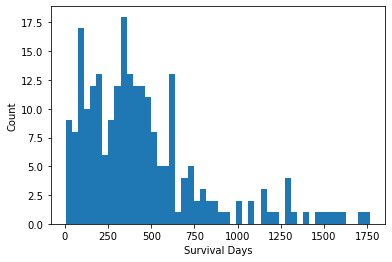

In [6]:
plt.hist(survival_info.Survival_days, bins=50)
plt.xlabel("Survival Days")
plt.ylabel("Count")
plt.show()

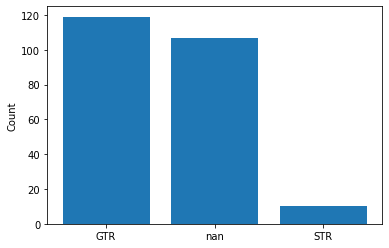

In [7]:
unqiue_restrictions = survival_info.Extent_of_Resection.value_counts(dropna=False)
unqiue_restriction_names = [str(i) for i in unqiue_restrictions.index]

plt.bar(unqiue_restriction_names, unqiue_restrictions.values)
plt.ylabel("Count")
plt.show()

# Images

In [8]:
import h5py
import numpy as np

In [9]:
def get_volume(idx, meta_data, data_path="data/BraTS2020_training_data"):
    
    df = meta_data[meta_data.volume == idx]
    
    for i, row in df.iterrows():
        path = Path(data_path).joinpath(row.slice_path)
        hf = h5py.File(path, 'r')
        img = np.array(hf.get("image"))
        mask = np.array(hf.get("mask"))
        yield {"image": img, "mask": mask, "slice": row.slice}

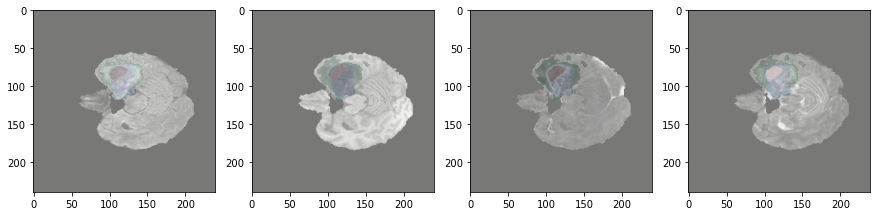

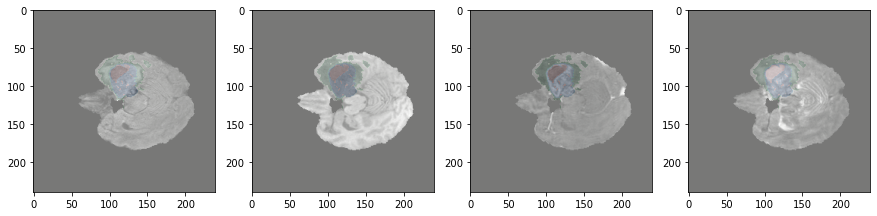

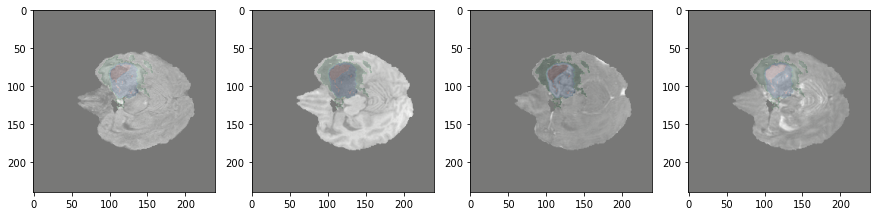

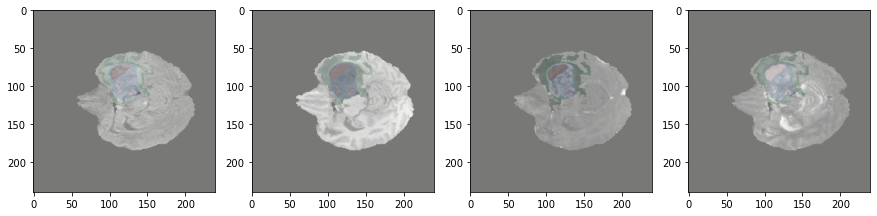

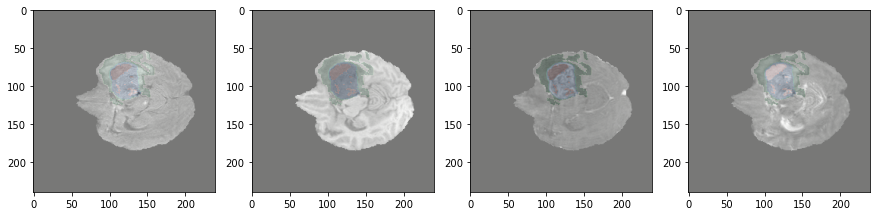

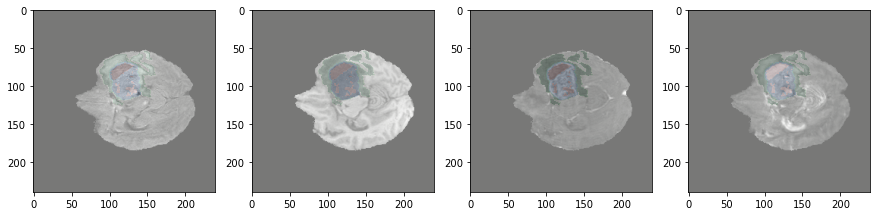

In [10]:
for i, data in enumerate(get_volume(1, meta_data)):
    
    if i > 50:
        fig, axs = plt.subplots(1, 4)
        fig.set_size_inches(15, 4)
        for j in range(4):
            axs[j].imshow(data["image"][..., j], cmap="gray")
            axs[j].imshow(data["mask"][..., 0], cmap="Reds", alpha=.2)
            axs[j].imshow(data["mask"][..., 1], cmap="Greens", alpha=.2)
            axs[j].imshow(data["mask"][..., 2], cmap="Blues", alpha=.2)

    if i > 55:
        break